In [100]:
import networkx as nx
import numpy as np
import itertools
import sys
import os
import random
import igraph as ig
#from networkx.algorithms import community
import community.community_louvain
import networkx.algorithms.isolate
import community as cm
import math
import random
import argparse
import matplotlib.pyplot as plt
import multiprocessing as mp
from numpy import linalg as LA
from   scipy.stats import percentileofscore

import pdb


def check_consensus_graph(G, n_p, delta):
    '''
    This function checks if the networkx graph has converged.
    Input:
    G: networkx graph
    n_p: number of partitions while creating G
    delta: if more than delta fraction of the edges have weight != n_p then returns False, else True
    '''



    count = 0

    for wt in nx.get_edge_attributes(G, 'weight').values():
        if wt != 0 and wt != n_p:
            count += 1

    if count > delta*G.number_of_edges():
        return False

    return True



def nx_to_igraph(Gnx):
    '''
    Function takes in a network Graph, Gnx and returns the equivalent
    igraph graph g
    '''
    g = ig.Graph()
    g.add_vertices(sorted(Gnx.nodes()))
    g.add_edges(sorted(Gnx.edges()))
    g.es["weight"] = 1.0
    for edge in Gnx.edges():
        g[edge[0], edge[1]] = Gnx[edge[0]][edge[1]]['weight']
    return g


def group_to_partition(partition):
    '''
    Takes in a partition, dictionary in the format {node: community_membership}
    Returns a nested list of communities [[comm1], [comm2], ...... [comm_n]]
    '''

    part_dict = {}

    for index, value in partition.items():

        if value in part_dict:
            part_dict[value].append(index)
        else:
            part_dict[value] = [index]


    return part_dict.values()

def check_arguments(args):

    if(args.d > 0.2):
        print('delta is too high. Allowed values are between 0.02 and 0.2')
        return False
    if(args.d < 0.02):
        print('delta is too low. Allowed values are between 0.02 and 0.2')
        return False
    if(args.alg not in ('louvain', 'lpm', 'cnm', 'infomap')):
        print('Incorrect algorithm entered. run with -h for help')
        return False
    if (args.t > 1 or args.t < 0):
        print('Incorrect tau. run with -h for help')
        return False

    return True

def louvain_community_detection(networkx_graph):
    """
    Do louvain community detection
    :param networkx_graph:
    :return:
    """
    return community.community_louvain.best_partition(networkx_graph)
#    return cm.partition_at_level(cm.generate_dendrogram(networkx_graph, randomize=True, weight='weight'), 0)

def get_yielded_graph(graph, times):
    """
    Creates an iterator containing the same graph object multiple times. Can be used for applying multiprocessing map
    """
    for _ in range(times):
        yield graph

def fast_consensus(G,  algorithm = 'louvain', n_p = 20, thresh = 0.2, delta = 0.02):
    graph = G.copy()
    L = G.number_of_edges()
    N = G.number_of_nodes()

#    for u,v in graph.edges():
#        graph[u][v]['weight'] = 1.0

    while(True):

        if (algorithm == 'louvain'):

            nextgraph = graph.copy()
            L = G.number_of_edges()
            for u,v in nextgraph.edges():
                nextgraph[u][v]['weight'] = 0.0


            with mp.Pool(processes=mp.cpu_count()) as pool:
                communities_all = pool.map(louvain_community_detection, get_yielded_graph(graph, n_p))



            for node,nbr in graph.edges():

                if (node,nbr) in graph.edges() or (nbr, node) in graph.edges():
                    if graph[node][nbr]['weight'] not in (0,n_p):
                        for i in range(n_p):
                            communities = communities_all[i]
                            if communities[node] == communities[nbr]:
                                nextgraph[node][nbr]['weight'] += 1
                            else:
                                nextgraph[node][nbr]['weight'] = graph[node][nbr]['weight']



            remove_edges = []
            for u,v in nextgraph.edges():
                if nextgraph[u][v]['weight'] < thresh*n_p:
                    remove_edges.append((u, v))

            nextgraph.remove_edges_from(remove_edges)



            if check_consensus_graph(nextgraph, n_p = n_p, delta = delta):
                break




            for _ in range(L):

                node = np.random.choice(nextgraph.nodes())
                neighbors = [a[1] for a in nextgraph.edges(node)]

                if (len(neighbors) >= 2):
                    a, b = random.sample(list(neighbors), 2)

                    if not nextgraph.has_edge(a, b):
                        nextgraph.add_edge(a, b, weight = 0)

                        for i in range(n_p):
                            communities = communities_all[i]

                            if communities[a] == communities[b]:
                                nextgraph[a][b]['weight'] += 1


            for node in nx.isolates(nextgraph):
                    nbr, weight = sorted(graph[node].items(), key=lambda edge: edge[1]['weight'])[0]
                    nextgraph.add_edge(node, nbr, weight = weight['weight'])


            graph = nextgraph.copy()


            if check_consensus_graph(nextgraph, n_p = n_p, delta = delta):
                break

        elif (algorithm in ('infomap', 'lpm')):

            nextgraph = graph.copy()

            for u,v in nextgraph.edges():
                nextgraph[u][v]['weight'] = 0.0

            if algorithm == 'infomap':
                communities = [{frozenset(c) for c in nx_to_igraph(graph).community_infomap().as_cover()} for _ in range(n_p)]
            if algorithm == 'lpm':
                communities = [{frozenset(c) for c in nx_to_igraph(graph).community_label_propagation().as_cover()} for _ in range(n_p)]


            for node, nbr in graph.edges():

                for i in range(n_p):
                    for c in communities[i]:
                        if node in c and nbr in c:
                            if not nextgraph.has_edge(node,nbr):
                                nextgraph.add_edge(node, nbr, weight = 0)
                            nextgraph[node][nbr]['weight'] += 1



            remove_edges = []
            for u,v in nextgraph.edges():
                if nextgraph[u][v]['weight'] < thresh*n_p:
                    remove_edges.append((u, v))
            nextgraph.remove_edges_from(remove_edges)



            for _ in range(L):
                node = np.random.choice(nextgraph.nodes())
                neighbors = [a[1] for a in nextgraph.edges(node)]

                if (len(neighbors) >= 2):
                    a, b = random.sample(set(neighbors), 2)

                    if not nextgraph.has_edge(a, b):
                        nextgraph.add_edge(a, b, weight = 0)

                        for i in range(n_p):
                            if a in communities[i] and b in communities[i]:
                                nextgraph[a][b]['weight'] += 1


            graph = nextgraph.copy()

            if check_consensus_graph(nextgraph, n_p = n_p, delta = delta):
                break

        elif (algorithm == 'cnm'):

            nextgraph = graph.copy()

            for u,v in nextgraph.edges():
                nextgraph[u][v]['weight'] = 0.0

            communities = []
            mapping = []
            inv_map = []


            for _ in range(n_p):

                order = list(range(N))
                random.shuffle(order)
                maps = dict(zip(range(N), order))

                mapping.append(maps)
                inv_map.append({v: k for k, v in maps.items()})
                G_c = nx.relabel_nodes(graph, mapping = maps, copy = True)
                G_igraph = nx_to_igraph(G_c)

                communities.append(G_igraph.community_fastgreedy(weights = 'weight').as_clustering())


            for i in range(n_p):

                edge_list = [(mapping[i][j], mapping[i][k]) for j,k in graph.edges()]

                for node,nbr in edge_list:
                    a, b = inv_map[i][node], inv_map[i][nbr]

                    if graph[a][b] not in (0, n_p):
                        for c in communities[i]:
                            if node in c and nbr in c:
                                nextgraph[a][b]['weight'] += 1

                    else:
                        nextgraph[a][b]['weight'] = graph[a][b]['weight']


            remove_edges = []
            for u,v in nextgraph.edges():
                if nextgraph[u][v]['weight'] < thresh*n_p:
                    remove_edges.append((u, v))

            nextgraph.remove_edges_from(remove_edges)


            for _ in range(L):
                node = np.random.choice(nextgraph.nodes())
                neighbors = [a[1] for a in nextgraph.edges(node)]

                if (len(neighbors) >= 2):
                    a, b = random.sample(list(neighbors), 2)
                    if not nextgraph.has_edge(a, b):
                        nextgraph.add_edge(a, b, weight = 0)

                        for i in range(n_p):
                            for c in communities[i]:
                                if mapping[i][a] in c and mapping[i][b] in c:

                                    nextgraph[a][b]['weight'] += 1

            if check_consensus_graph(nextgraph, n_p, delta):
                break

        else:
            break

    if (algorithm == 'louvain'):
#        with mp.Pool(processes=mp.cpu_count()) as pool:
#            communities_all = pool.map(louvain_community_detection, get_yielded_graph(graph, n_p))
#        return communities_all
        return louvain_community_detection(graph)
    if algorithm == 'infomap':
        return [{frozenset(c) for c in nx_to_igraph(graph).community_infomap().as_cover()} for _ in range(n_p)]
    if algorithm == 'lpm':
        return [{frozenset(c) for c in nx_to_igraph(graph).community_label_propagation().as_cover()} for _ in range(n_p)]
    if algorithm == 'cnm':

        communities = []
        mapping = []
        inv_map = []

        for _ in range(n_p):
            order = list(range(N))
            random.shuffle(order)
            maps = dict(zip(range(N), order))

            mapping.append(maps)
            inv_map.append({v: k for k, v in maps.items()})
            G_c = nx.relabel_nodes(graph, mapping = maps, copy = True)
            G_igraph = nx_to_igraph(G_c)

            communities.append(G_igraph.community_fastgreedy(weights = 'weight').as_clustering())

        return communities


def compute_C_minus_C0(lambdas,v,lambda_plus):
    N=len(lambdas)
    C_clean=np.zeros((N, N))

    v_m=np.matrix(v)

    lambda_max=max(lambdas)

    for i in range(N):
        if lambdas[i]>lambda_plus and lambdas[i]<lambda_max:
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)
    return C_clean


def compute_C_minus_C0_as_graph(R):
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2

    C=R.corr()
    lambdas, v = LA.eigh(C)

    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]


    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)

    mygraph= nx.from_numpy_array(np.abs(C_s))
    return mygraph




In [40]:
import pandas as pd

In [41]:
DF=pd.read_parquet("sp500_20161229.parquet")

DF.set_index("index",inplace=True)

In [52]:
T = 100
Ds_interm = []
num_windows = len(DF) // T

for i in range(num_windows):
    t0 = i * T
    t1 = t0 + T

    mydata = DF.iloc[t0:t1].copy()
    mydata.dropna(axis=1, inplace=True)
    G = compute_C_minus_C0_as_graph(mydata.T)
    D = fast_consensus(G)
    D_interm = pd.DataFrame({'Date': mydata.index, 'state': list(D.values())})
    Ds_interm.append(D_interm)

D = pd.concat(Ds_interm, ignore_index=True)

In [45]:
D_copy=D.copy()
group_indices = (D_copy.index // 100) * 100
group_means = D_copy.groupby(group_indices)['state'].nunique()
D_copy['mean_state'] = group_means.reindex(D_copy.index, method='ffill')

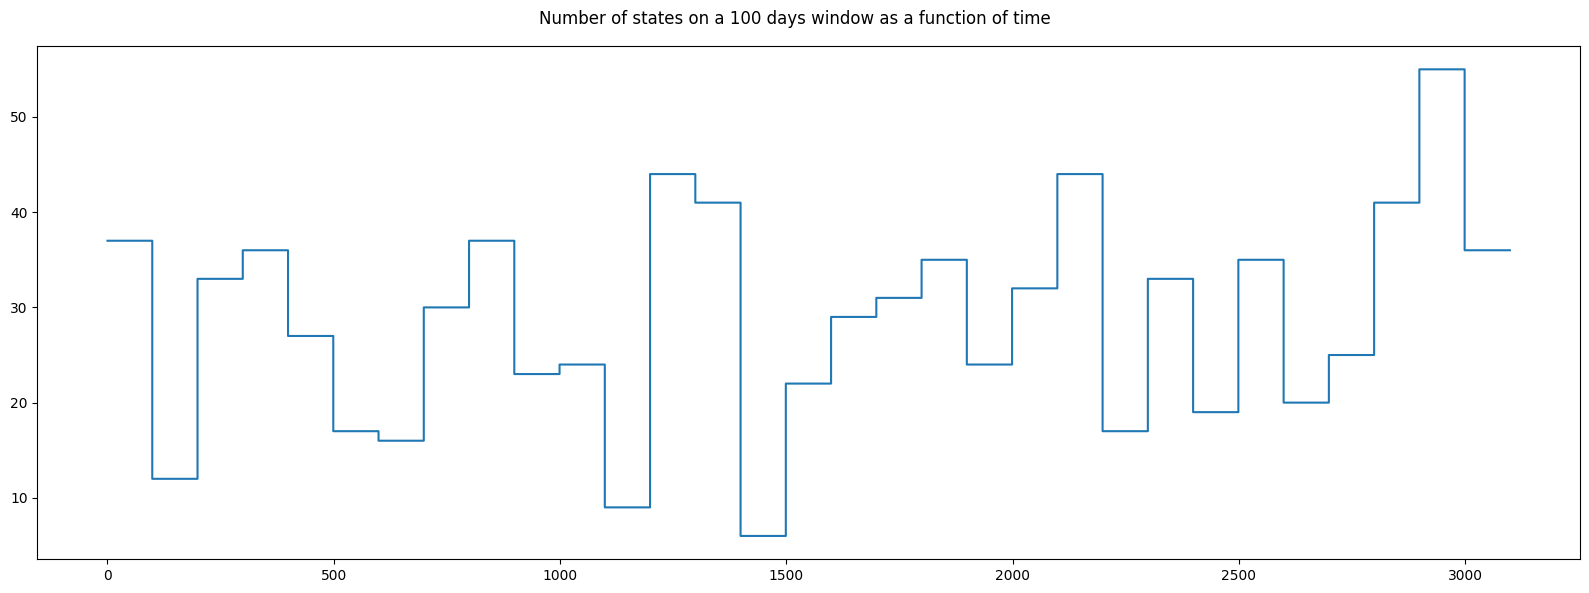

In [46]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'Number of states on a 100 days window as a function of time')
ax.step(D_copy.index,D_copy['mean_state'])

plt.tight_layout()
plt.show()

We notice that the number of states is not constant it varies with time and is quite volatile (however it seems like there is an upward tendancy in the number of states)

## State based strategies

Let us consider two strategies, one is trend following and the other one is mean reverting.

1) Trend following strategy

In this trend following strategy, we devide the timescale in windows of size 100. At the beginning of every new window (current_day) we look at the previous day's state. We then determine all the days that had the same previous day's state as the current day's previous day's state.\

On these days we calculate the mean return of each stock and w select those who had the greatest value of mean return (for example the best 20 stocks)

On the next window of 100 days we will be longing these stocks and we rebalance our strategy on the next 100 days

In [54]:
DF=DF[:num_windows*T]

In [65]:
DF_states=DF.copy()
DF_states['state']=D['state'].values

In [98]:

T = 100
selection_threshhold=20
Returns = []

for i in range(num_windows):

    t0 = i * T
    t1 = t0 + T

    mydata = DF_states.iloc[t0:t1].copy()
    last_day_state=mydata['state'][-2]
    mydata['previous_state']=mydata['state'].shift(1)

    selected_data=mydata[mydata['previous_state']==last_day_state]
    selected_data.drop(columns=['previous_state','state'],inplace=True)
    selected_data_mean_return=pd.DataFrame(selected_data.mean())

    top_selected_stocks = selected_data_mean_return[0].nlargest(selection_threshhold)
    top_selected_stock_names = top_selected_stocks.index.tolist()


    mydata= DF.iloc[t0+T:t1+T].copy()
    selected_performances=mydata[top_selected_stock_names]
    selected_performances['return'] =  selected_performances.sum(axis=1)/len(selected_performances)
    Returns.append(selected_performances['return'])

All_returns=pd.concat(Returns)

<ipython-input-98-39a58fbe31e8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data.drop(columns=['previous_state','state'],inplace=True)
<ipython-input-98-39a58fbe31e8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_performances['return'] =  selected_performances.sum(axis=1)/len(selected_performances)
<ipython-input-98-39a58fbe31e8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

<Axes: xlabel='index'>

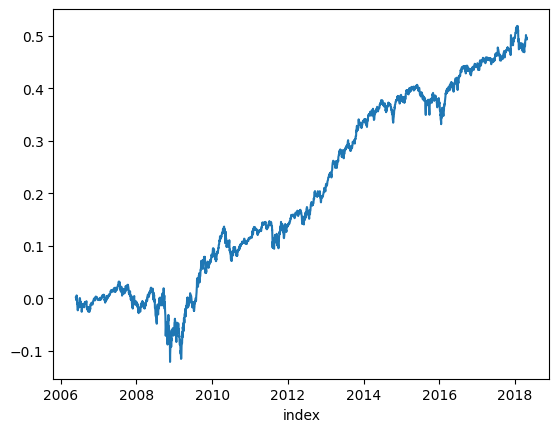

In [99]:
((1+All_returns).cumprod() -1).plot()

This strategy seems to have good results

2) Mean reverting strategy

In this trend following strategy, we devide the timescale in windows of size 100. At the beginning of every new window (current_day) we look at the previous day's state. We then determine all the days that had the same previous day's state as the current day's previous day's state.\

On these days we calculate the mean return of each stock.\
We then divide these stocks in 4 categories :

*   Stocks that have their mean return above the 80% quantile of the selected mean returns, we'd believe that these stocks's returns will be falling down on the next 100 timesteps
*   Stocks that have their mean return below the 20% quantile of the selected mean returns, we'd believe that these stocks's returns will be increasing on the next 100 timesteps

*   Stocks that have their mean return between the 50% and the 80% quantile of the selected mean returns, we'd believe that these stocks's returns will keep on increasing on the next 100 timesteps
*   Stocks that have their mean return between the 20% and the 50% quantile of the selected mean returns, we'd believe that these stocks's returns will keep on decreasing on the next 100 timesteps




On the next window of 100 days we will be longing these stocks and we rebalance our strategy on the next 100 days

In [140]:
T = 100
selection_threshhold=20
Returns = []
upper_threshold=80
lower_threshold=20
for i in range(num_windows):

    t0 = i * T
    t1 = t0 + T

    mydata = DF_states.iloc[t0:t1].copy()
    last_day_state=mydata['state'][-2]
    mydata['previous_state']=mydata['state'].shift(1)

    selected_data=mydata[mydata['previous_state']==last_day_state]
    selected_data.drop(columns=['previous_state','state'],inplace=True)
    selected_data_mean_return=pd.DataFrame(selected_data.mean())
    selected_data_mean_return.dropna(inplace=True)

    selected_data_mean_return['percentile_rank'] = selected_data_mean_return.apply(lambda x: percentileofscore(selected_data_mean_return[0].values,x), axis=1)


    #print(selected_data_mean_return)
    stocks_above_upper_quantile = selected_data_mean_return[selected_data_mean_return['percentile_rank'] > upper_threshold].index.tolist()
    stocks_below_lower_quantile = selected_data_mean_return[selected_data_mean_return['percentile_rank'] < lower_threshold].index.tolist()
    stocks_between_lower_50_quantile = selected_data_mean_return[
        (selected_data_mean_return['percentile_rank'] >= lower_threshold) & (selected_data_mean_return['percentile_rank'] < 50)].index.tolist()
    stocks_between_50_upper_quantile = selected_data_mean_return[
        (selected_data_mean_return['percentile_rank'] >= 50) & (selected_data_mean_return['percentile_rank'] < upper_threshold)].index.tolist()

    mydata= DF.iloc[t0+T:t1+T].copy()

    selected_performances_upper=mydata[stocks_above_upper_quantile]
    selected_performances_lower=mydata[stocks_below_lower_quantile]
    selected_performances_lower_50=mydata[stocks_between_lower_50_quantile]
    selected_performances_50_upper=mydata[stocks_between_50_upper_quantile]

    Performances=pd.DataFrame()
     # Assign returns based on quantile ranges
    Performances['low return'] = selected_performances_lower.sum(axis=1) / len(DF.columns)
    Performances['mid upp return'] = selected_performances_50_upper.sum(axis=1) / len(DF.columns)
    Performances['upp return'] = -selected_performances_upper.sum(axis=1) / len(DF.columns)
    Performances['low mid return'] = -selected_performances_lower_50.sum(axis=1) / len(DF.columns)

    sum_of_performances = Performances.sum(axis=1)

    # Concatenate the returns of different quantile ranges

    Returns.append(sum_of_performances)

All_returns=pd.concat(Returns)

<ipython-input-140-ec200ba97aab>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data.drop(columns=['previous_state','state'],inplace=True)
<ipython-input-140-ec200ba97aab>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data.drop(columns=['previous_state','state'],inplace=True)
<ipython-input-140-ec200ba97aab>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data.drop(columns=['previous_state','state'],

<Axes: >

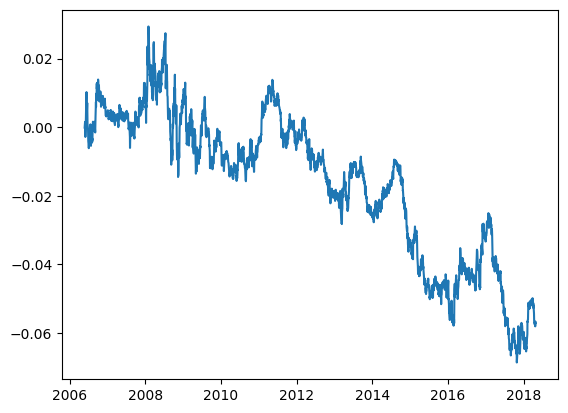

In [141]:
((1+All_returns).cumprod() -1).plot()

The performances of this strategy are not good as they are negative most of the time